In [33]:
# Jupyter Notebook

# Importando as bibliotecas necessárias
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


# Configurações iniciais
sns.set(style="whitegrid")
pd.options.mode.chained_assignment = None  # Para evitar warnings de cópias de DataFrame

# Configurando os diretórios
input_dir = Path("runs")
output_dir = Path("results")
output_dir.mkdir(exist_ok=True)





## Execução da Simulação

In [34]:
def main():
    # Activate virtual environment (if needed, adjust path accordingly)
    venv_path = os.path.join(os.getcwd(), "venv")
    if os.path.exists(venv_path):
        activate_script = os.path.join(venv_path, "bin", "activate_this.py")
        with open(activate_script) as f:
            exec(f.read(), {'__file__': activate_script})

        # Read kernel_dir from config.json
    with open("config.json") as config_file:
        config = json.load(config_file)
        #kernel_dir = config["paths"]["kernel"]
        analisys_dir = config["paths"]["analisys"]
        kernel_dir = config["paths"]["kernel"]
        results_dir = config["paths"]["results"]
        runs_dir = config["paths"]["runs"]
        model_file = config["files"]["model"]
        scenarios_file = config["files"]["scenarios"]
        analisys_file = config["files"]["analisys"]



    # Remove CSV files in the 'runs' directory
    if os.path.exists(runs_dir):
        for file in os.listdir(runs_dir):
            if file.endswith(".csv"):
                os.remove(os.path.join(runs_dir, file))

    # Get current directory as app_dir
    app_dir = os.getcwd()


    # Change directory to kernel_dir and run ecosimp.py
    os.chdir(kernel_dir)
    subprocess.run(["python3", "ecosimp.py", app_dir, model_file, scenarios_file], check=True)

    # Change back to the original directory
    os.chdir(app_dir)


if __name__ == "__main__":
    main()

Scenario: Scenario1 Run nr.: 2: 100%|██████████| 1000/1000 [00:00<00:00, 2754.63it/s]


## Análise do Resultado

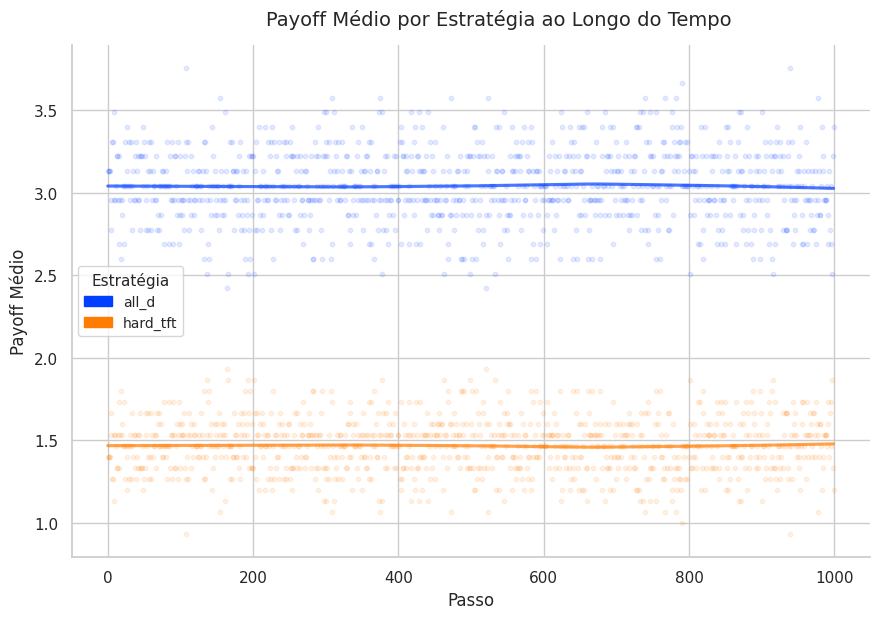

/tmp/ipykernel_12527/674545806.py:126: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipykernel_12527/674545806.py:126: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


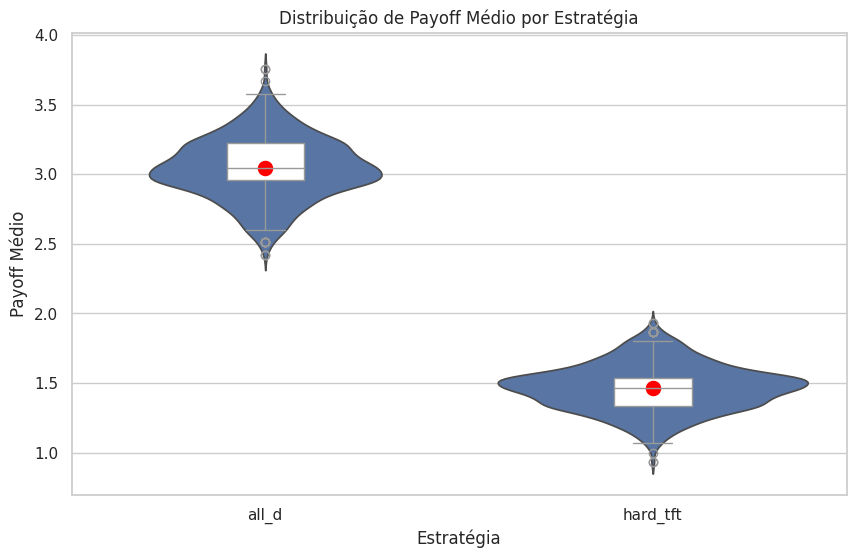

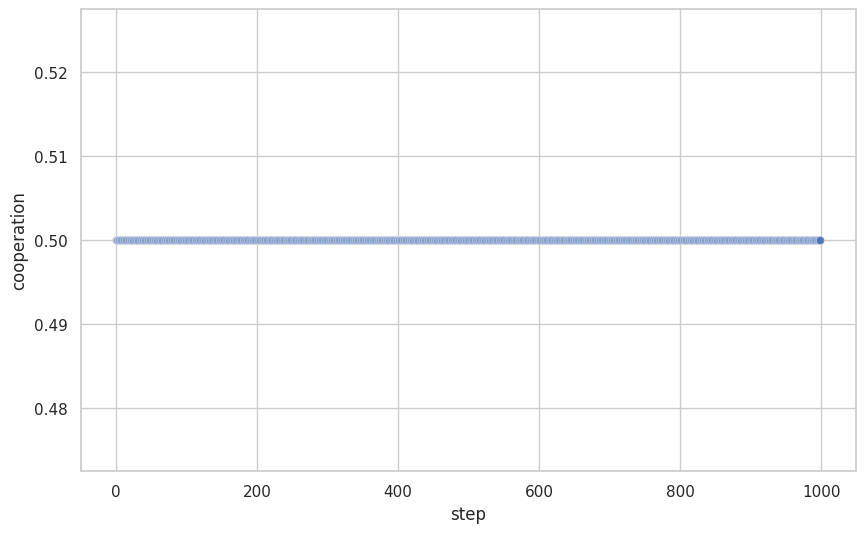

<Figure size 1000x600 with 0 Axes>

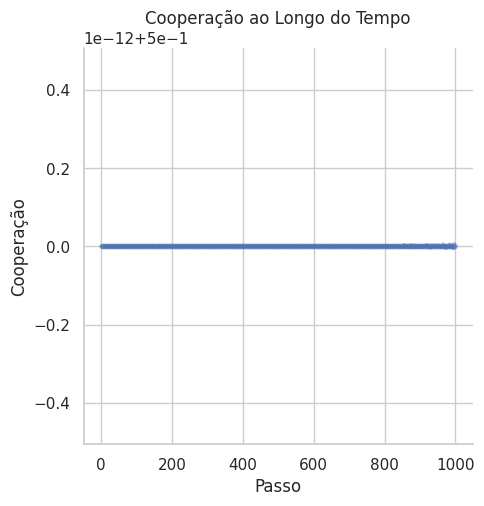

In [35]:

# Obtendo os arquivos CSV
csv_files = list(input_dir.glob("*.csv"))

# Gerando o DataFrame consolidado
runs_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
runs_df_or = runs_df.copy()
runs_df = runs_df.dropna()

# Calculando a diferença de payoffs
runs_df["diff_payoffs"] = runs_df["my_payoff"] - runs_df["other_payoff"]

# Agrupando os dados para calcular médias e somas de payoffs
sum_runs = (
    runs_df.groupby(["scenario", "step", "strategy_name"])
    .agg(
        payoff_mean=("my_payoff", "mean"),
        payoff_sum=("my_payoff", "sum"),
    )
    .reset_index()
)

# Calculando cooperação e defecção
sum_cooperation = (
    runs_df.groupby(["scenario", "step"])
    .agg(
        my_play_C=("my_play", lambda x: (x == "C").sum()),
        my_play_D=("my_play", lambda x: (x == "D").sum()),
        ot_play_C=("other_play", lambda x: (x == "C").sum()),
        ot_play_D=("other_play", lambda x: (x == "D").sum()),
        players=("my_play", "count"),
    )
    .reset_index()
)

sum_cooperation["cooperation"] = sum_cooperation["my_play_C"] / sum_cooperation["players"]
sum_cooperation["defection"] = sum_cooperation["my_play_D"] / sum_cooperation["players"]

# # Gráfico 1: Payoff médio por estratégia ao longo do tempo
# plt.figure(figsize=(10, 6))
# sns.lmplot(data=sum_runs, 
#             x="step", 
#             y="payoff_mean",
#             hue="strategy_name",
#             scatter=True, 
#             lowess=True, 
#             line_kws={"alpha": 0.5},
#             scatter_kws={"alpha": 0.1, "s": 10})

# plt.title("Payoff Médio por Estratégia ao Longo do Tempo")
# plt.xlabel("Passo")
# plt.ylabel("Payoff Médio")
# #plt.legend(title="Estratégia")
# plt.savefig(output_dir / "payoff_mean_by_strategy.png")
# plt.show()

# sns.set(style="whitegrid")  # Estilo mais limpo

# Gráfico com lmplot precisa ser salvo em um objeto para manipulação
# g = sns.lmplot(data=sum_runs, 
#                x="step", 
#                y="payoff_mean",
#                hue="strategy_name",
#                palette= "deep",
#                scatter=True, 
#                lowess=True, 
#                line_kws={"alpha": 0.7},
#                scatter_kws={"alpha": 0.1, "s": 10},
#                height=6, aspect=1.5)

# # Títulos e eixos
# g.set_axis_labels("Passo", "Payoff Médio")
# g.fig.suptitle("Payoff Médio por Estratégia ao Longo do Tempo", fontsize=14, y=1.03)

# # Legenda personalizada
# g._legend.set_title("Estratégia")  # Título da legenda
# for text in g._legend.texts:
#     text.set_fontsize(10)  # Ajustar tamanho da fonte


# # Salvar e mostrar
# plt.savefig(output_dir / "payoff_mean_by_strategy.png", bbox_inches="tight")
# plt.show()

from matplotlib.patches import Patch

# Gera uma paleta mais saturada
unique_strategies = sum_runs["strategy_name"].unique()
palette = sns.color_palette("bright", n_colors=len(unique_strategies))

# Cria um mapeamento de cores
color_dict = dict(zip(unique_strategies, palette))

# Recria o lmplot com a paleta
g = sns.lmplot(
    data=sum_runs, 
    x="step", 
    y="payoff_mean",
    hue="strategy_name",
    palette=color_dict,
    scatter=True, 
    lowess=True, 
    line_kws={"alpha": 0.7},
    scatter_kws={"alpha": 0.1, "s": 10},
    height=6, aspect=1.5
)

# Títulos e eixos
g.set_axis_labels("Passo", "Payoff Médio")
g.fig.suptitle("Payoff Médio por Estratégia ao Longo do Tempo", fontsize=14, y=1.03)

# Remove a legenda original
g._legend.remove()

# Cria legenda personalizada com patches coloridos e mais saturados
handles = [Patch(color=color_dict[strategy], label=strategy) for strategy in unique_strategies]
g.ax.legend(handles=handles, title="Estratégia", fontsize=10, title_fontsize=11)

# Salvar e mostrar
plt.savefig(output_dir / "payoff_mean_by_strategy.png", bbox_inches="tight")
plt.show()

# Gráfico 2: Distribuição de payoff médio por estratégia
plt.figure(figsize=(10, 6))
sns.violinplot(data=sum_runs, x="strategy_name", y="payoff_mean", inner=None)
sns.boxplot(data=sum_runs, x="strategy_name", y="payoff_mean", width=0.2, color="white")
sns.pointplot(
    data=sum_runs,
    x="strategy_name",
    y="payoff_mean",
    color="red",
    join=False,
    markers="o",
    scale=1.5,
)
plt.title("Distribuição de Payoff Médio por Estratégia")
plt.xlabel("Estratégia")
plt.ylabel("Payoff Médio")
plt.savefig(output_dir / "payoff_distribution_by_strategy.png")
plt.show()

# Gráfico 3: Cooperação ao longo do tempo
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sum_cooperation, 
                x="step", 
                y="cooperation", 
                alpha=0.5
                )

plt.figure(figsize=(10, 6))
sns.lmplot(data=sum_cooperation, 
           x="step", 
           y="cooperation", 
           scatter=True, 
            lowess=True, 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10}
            )

plt.title("Cooperação ao Longo do Tempo")
plt.xlabel("Passo")
plt.ylabel("Cooperação")
plt.savefig(output_dir / "cooperation_over_time.png")
plt.show()

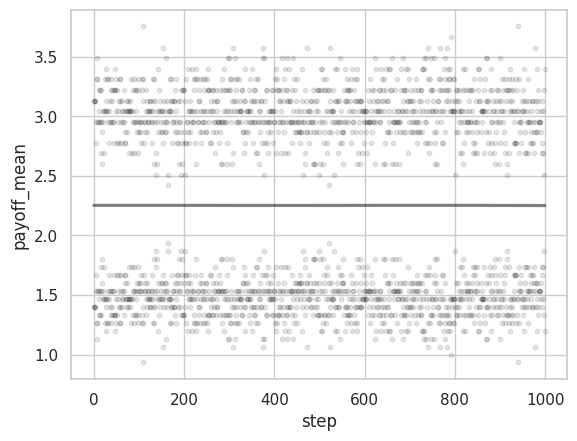

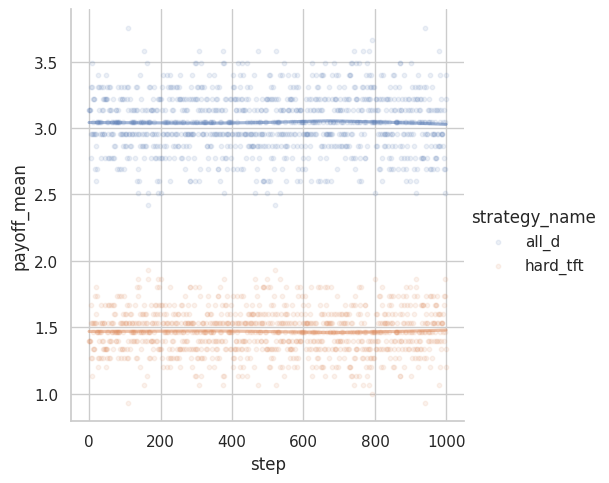

In [36]:
sns.regplot(data=sum_runs, 
            x="step", 
            y="payoff_mean",
            label="strategy_name",
            scatter=True, 
            lowess=True, 
            color="black", 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10})


sns.lmplot(data=sum_runs, 
            x="step", 
            y="payoff_mean",
            hue="strategy_name",
            scatter=True, 
            lowess=True, 
            line_kws={"alpha": 0.5},
            scatter_kws={"alpha": 0.1, "s": 10})
